In [1]:
from typing import Annotated
from typing import Literal
from langchain_community.tools.tavily_search import TavilySearchResults
from langchain_core.tools import tool
from langchain_experimental.utilities import PythonREPL
from typing_extensions import TypedDict
from langgraph.graph import MessagesState, END,StateGraph, START
from langgraph.types import Command
from langchain_core.messages import HumanMessage
from langgraph.prebuilt import create_react_agent

In [2]:
from dotenv import load_dotenv

In [3]:
load_dotenv()

True

## Loading the model

In [4]:
from langchain_groq import ChatGroq
groq_model=ChatGroq(model="deepseek-r1-distill-llama-70b")

In [5]:
groq_model.invoke("hi").content

'<think>\n\n</think>\n\nHello! How can I assist you today? 😊'

In [6]:
response=groq_model.invoke("hi")

In [7]:
response.content

'<think>\n\n</think>\n\nHello! How can I assist you today? 😊'

In [8]:
def clean_text(text):
    import re
    clean_text = re.sub(r'<think>.*?</think>\s*', '', text, flags=re.DOTALL)
    return clean_text# Remove extra whitespace

In [9]:
clean_text(response.content)

'Hello! How can I assist you today? 😊'

In [10]:
TAVILY_API_KEY = "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"


import os
os.environ["TAVILY_API_KEY"] = TAVILY_API_KEY

In [11]:
tavaily_tool = TavilySearchResults()

In [12]:
tavaily_tool.invoke("what is a gdp?")

[{'title': 'Beginners:GDP - What is gross domestic product (GDP)?',
  'url': 'https://ec.europa.eu/eurostat/statistics-explained/index.php/Beginners:GDP_-_What_is_gross_domestic_product_(GDP)%3F',
  'content': 'GDP "Glossary:Gross domestic product (GDP)") is the most common measure for the size of an economy. It measures the total value of goods and services produced by that economy during a specific time period, typically a year or a quarter, so it helps us understand the size of an economy and the standard of living of its population. [...] GDP is a key measure within a wider framework of economic statistics which is often simply referred to as national accounts. The European system of national and regional accounts (ESA) defines the binding standards and methods used for compiling these accounts, whereas the global standard set by the United Nations (UN) is called the System of National Accounts (SNA) "Glossary:System of national accounts (SNA)").\n\nGDP can be calculated in 3 ways,

In [13]:
code = """
x = 5
y = x * 2
print(y)
"""

In [14]:
repl=PythonREPL()

In [15]:
repl.run(code)

Python REPL can execute arbitrary code. Use with caution.


'10\n'

In [16]:
@tool
def python_repl_tool(
    code: Annotated[str, "The python code to execute to generate your chart."],
):
    """Use this to execute python code and do math. If you want to see the output of a value,
    you should print it out with `print(...)`. This is visible to the user."""
    
    try:
        result = repl.run(code)
    except BaseException as e:
        return f"Failed to execute. Error: {repr(e)}"
    
    result_str = f"Successfully executed:\n\`\`\`python\n{code}\n\`\`\`\nStdout: {result}"
    return result_str

<>:13: SyntaxWarning: invalid escape sequence '\`'
<>:13: SyntaxWarning: invalid escape sequence '\`'
<>:13: SyntaxWarning: invalid escape sequence '\`'
<>:13: SyntaxWarning: invalid escape sequence '\`'
C:\Users\souma\AppData\Local\Temp\ipykernel_13260\3901756031.py:13: SyntaxWarning: invalid escape sequence '\`'
  result_str = f"Successfully executed:\n\`\`\`python\n{code}\n\`\`\`\nStdout: {result}"
C:\Users\souma\AppData\Local\Temp\ipykernel_13260\3901756031.py:13: SyntaxWarning: invalid escape sequence '\`'
  result_str = f"Successfully executed:\n\`\`\`python\n{code}\n\`\`\`\nStdout: {result}"


In [17]:
print(python_repl_tool.invoke(code))

Successfully executed:
\`\`\`python

x = 5
y = x * 2
print(y)

\`\`\`
Stdout: 10



In [18]:
members = ["researcher","coder"]

In [19]:
options = members+["FINISH"]

In [20]:
options

['researcher', 'coder', 'FINISH']

In [21]:
class Router(TypedDict):
    """Worker to route to next. If no workers needed, route to FINISH."""
    next: Literal['researcher', 'coder', 'FINISH']

In [22]:
class State(MessagesState):
    next:str

In [23]:
system_prompt=f"""
You are a supervisor, tasked with managing a conversation between the following workers: {members}. 
Given the following user request, respond with the worker to act next. 
Each worker will perform a task and respond with their results and status. 
When finished, respond with FINISH.
"""

In [25]:
[{"role": "system", "content": system_prompt},]

[{'role': 'system',
  'content': "\nYou are a supervisor, tasked with managing a conversation between the following workers: ['researcher', 'coder'].\nGiven the following user request, respond with the worker to act next.\nEach worker will perform a task and respond with their results and status.\nWhen finished, respond with FINISH.\n\nRules:\n- If the user query requires web search or factual information, route to 'researcher'.\n- If the user query requires math, calculations, or code execution, route to 'coder'.\n- Do NOT route math or code questions to 'researcher'.\n"}]

In [26]:
state={"next":["hi"]}

In [27]:
state["next"]

['hi']

In [28]:
[{"role": "system", "content": system_prompt},] + state["next"]

[{'role': 'system',
  'content': "\nYou are a supervisor, tasked with managing a conversation between the following workers: ['researcher', 'coder'].\nGiven the following user request, respond with the worker to act next.\nEach worker will perform a task and respond with their results and status.\nWhen finished, respond with FINISH.\n\nRules:\n- If the user query requires web search or factual information, route to 'researcher'.\n- If the user query requires math, calculations, or code execution, route to 'coder'.\n- Do NOT route math or code questions to 'researcher'.\n"},
 'hi']

In [29]:
def supervisor_node(state: State) -> Command[Literal["researcher", "coder", "__end__"]]:
    
    messages = [{"role": "system", "content": system_prompt},] + state["messages"]
    
    response = groq_model.with_structured_output(Router).invoke(messages)
    
    goto = response["next"]
    
    print("below my goto**********************************")
    
    print(goto)
    
    if goto == "FINISH":
        goto = END
        
    return Command(goto=goto, update={"next": goto})

In [30]:
def research_node(state: State) -> Command[Literal["supervisor"]]:
    
    research_agent = create_react_agent(groq_model, tools=[tavaily_tool], prompt="You are a researcher. DO NOT do any math.")
    
    result = research_agent.invoke(state)
    
    return Command(
        update={
            "messages": [
                HumanMessage(content=result["messages"][-1].content, name="researcher")
            ]
        },
        goto="supervisor",
    )

In [31]:
def code_node(state: State) -> Command[Literal["supervisor"]]:
    
    code_agent = create_react_agent(groq_model, tools=[python_repl_tool])
    
    result = code_agent.invoke(state)
    
    return Command(
        update={
            "messages": [
                HumanMessage(content=result["messages"][-1].content, name="coder")
            ]
        },
        goto="supervisor",
    )


In [33]:
graph=StateGraph(State)

In [34]:
graph.add_node("supervisor",supervisor_node)

In [35]:
graph.add_node("researcher", research_node)

In [36]:
graph.add_node("coder", code_node)

In [37]:
graph.add_edge(START,"supervisor")


In [38]:
app=graph.compile()

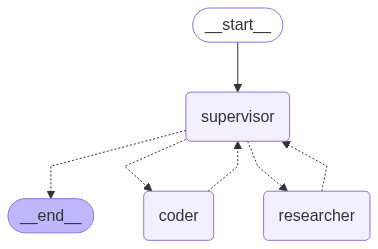

In [39]:
from IPython.display import display, Image

display(Image(app.get_graph().draw_mermaid_png()))

In [ ]:
# With the graph created, we can now invoke it and see how it performs!
for s in app.stream({"messages": [("user", "What's the square root of 42?")]}, subgraphs=True):
    print(s)
    print("----")

below my goto**********************************
coder
((), {'supervisor': {'next': 'coder'}})
----
(('coder:497f80cf-2f9c-fee3-5565-8927f37ecd0c',), {'agent': {'messages': [AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'aezm7xa79', 'function': {'arguments': '{"code":"import math\\nprint(math.sqrt(42))"}', 'name': 'python_repl_tool'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 197, 'prompt_tokens': 215, 'total_tokens': 412, 'completion_time': 0.743079704, 'prompt_time': 0.028310995, 'queue_time': 0.085641318, 'total_time': 0.771390699}, 'model_name': 'deepseek-r1-distill-llama-70b', 'system_fingerprint': 'fp_1bbe7845ec', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run--4e858b54-a9c6-4b95-936e-7724133f2efe-0', tool_calls=[{'name': 'python_repl_tool', 'args': {'code': 'import math\nprint(math.sqrt(42))'}, 'id': 'aezm7xa79', 'type': 'tool_call'}], usage_metadata={'input_tokens': 215, 'output_tokens': 197, 'total_tokens': 412})]

In [49]:
app.invoke({"messages": [("user", "What's the square root of 42?")]}, subgraphs=True)

below my goto**********************************
researcher
below my goto**********************************
researcher
below my goto**********************************
researcher
below my goto**********************************
researcher
below my goto**********************************
researcher
below my goto**********************************
researcher
below my goto**********************************
researcher


BadRequestError: Error code: 400 - {'error': {'message': "Failed to call a function. Please adjust your prompt. See 'failed_generation' for more details.", 'type': 'invalid_request_error', 'code': 'tool_use_failed', 'failed_generation': '\n\nThe square root of 42 is approximately 6.48.'}}

In [109]:
app.invoke({"messages": [("user", "What is an efficient Python code to get prime numbers?")]}, subgraphs=True)

below my goto**********************************
coder
below my goto**********************************
coder
below my goto**********************************
FINISH


((),
 {'messages': [HumanMessage(content='What is an efficient Python code to get prime numbers?', additional_kwargs={}, response_metadata={}, id='3ea6d4d1-bf79-4962-aeb7-b4ab9d61236b'),
   HumanMessage(content='To efficiently find prime numbers using Python, the Sieve of Eratosthenes algorithm is a highly effective method. Here\'s an implementation of the Sieve of Eratosthenes:\n\n<tool_call>{"name": "python_repl_tool", "arguments": {"code": "def sieve_of_eratosthenes(n):\\n    if n < 2:\\n        return []\\n    prime = [True] * (n + 1)\\n    prime[0], prime[1] = False, False\\n    for i in range(2, int(n ** 0.5) + 1):\\n        if prime[i]:\\n            for j in range(i*i, n+1, i):\\n                prime[j] = False\\n    primes = [i for i, is_prime in enumerate(prime) if is_prime]\\n    return primes\\n\\nprint(sieve_of_eratosthenes(20))"}}', additional_kwargs={}, response_metadata={}, name='coder', id='301bd894-8096-4ab7-87b8-e4796f363704'),
   HumanMessage(content="The Sieve of 